In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
# Deep Learning
#import tensorflow as tf

In [2]:
def add_data_info():
    df1 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-points-from-2017.csv', encoding= 'unicode_escape', low_memory=False)
    df2 = pd.read_csv('raw_data/charting-m-matches.csv', encoding= 'unicode_escape', low_memory=False)
    
    #get separated values from m-matches list of games - based on matchid
    df = pd.merge(df1,df2[['match_id','Date','Tournament','Round','Surface','Player 1','Player 2']], on=['match_id'], how='left')
    
    #add the condition of "Grand Slam" - 5 or 3 sets
    conditions = df['Tournament'].isin(["Wimbledon", "Australian Open", "US Open", "Roland Garros"])
    values = [1,0]

    # Create a new column  based on the conditions and values
    df['Grand Slam'] = pd.Series(pd.NA)
    df.loc[conditions, 'Grand Slam'] = values[0]
    df.loc[~conditions, 'Grand Slam'] = values[1]
    
    # save the original dataset with enriched data for future features
    df.to_csv('raw_data/charting-m-points-from-2017-enriched.csv', index=False)

In [3]:
def filter_player(df,opponent):
    
    # Read the dataset into a pandas DataFrame - from enriched file
    df = pd.read_csv(df, encoding= 'unicode_escape', low_memory=False)
    
    ## filtra pelo  oponente
    df = df[(df["Player 1"].str.contains(opponent)) | (df["Player 2"].str.contains(opponent))].copy()
    
    ##define se está sacando e se ganhou o ponto
    df['i_serve'] = np.where(((df['Svr'] == 1) & (df['Player 1'] == opponent )) | ((df['Svr'] == 2) & (df['Player 2'] == opponent)), 0, 1)
    df['i_win'] = np.where(((df['isSvrWinner'] == df['i_serve'])), 1, 0)
    df['is_second_service'] = np.where(((df['2nd'].isnull())), 0, 1)
    
    ## direção do saque
    # primeiro caractere do segundo saque
    df['dir_srv'] = df.loc[:, '2nd'].str[0]
    ## completa com o primeiro caractere do primeiro saque quando ele entrou
    df['dir_srv'].fillna(df.loc[:, '1st'].str[0], inplace=True)

    
    ##reseta o indice
    df.reset_index(inplace=True)
    
    ## salva arquivo e retorna dataset da funcao
    csv_file = "raw_data/" + opponent + "_points.csv"
    df.to_csv(csv_file, index=False)
    return df

In [4]:
meaning_char = pd.read_csv('https://raw.githubusercontent.com/eduardoscovino/tennis-analytics/master/code_map.csv',
                           encoding= 'unicode_escape', sep=';')

In [5]:
add_data_info()

In [6]:
df = filter_player('raw_data/charting-m-points-from-2017-enriched.csv','Novak Djokovic')

In [7]:
## serve direction encode 
df = df[df['dir_srv'].isin(['4','5','6'])]

## to numeric for rallyCount and serve direction
df['rallyCount']=pd.to_numeric(df['rallyCount'])
df['dir_srv']=pd.to_numeric(df['dir_srv'])

In [8]:
#Spliting Serve and Return
df['rally_desc'] = df.loc[:, '2nd']
df['rally_desc'].fillna(df.loc[:, '1st'], inplace=True)

##df['Serve'] = df.loc[:, 'rally_desc'].str[0:1]

df['rally_desc'] = df['rally_desc'].str[1:]

sc = np.array(meaning_char[~meaning_char['code'].isin(['f', 'b', 'r', 's', 'v', 'l', 'o', 'z', 'p', 'u', 'y', 'h', 'i', 'j', 'k','m', '1', '2', '3', '7', '8', '9'])]['code'])

#Spliting every shot
df['rally_desc'] = df['rally_desc'].apply(lambda x: ''.join([c for c in x if c not in sc]))
df['rally_desc'] = df['rally_desc'].str.replace('f',' f').str.replace('b',' b').str.replace('s',' s').str.replace('r',' r').str.replace('v',' v').str.replace('l',' l').str.replace('o',' o').str.replace('z',' z').str.replace('p',' p').str.replace('u',' u').str.replace('y',' y').str.replace('h',' h').str.replace('i',' i').str.replace('j',' j').str.replace('k',' k').str.replace('m',' m').str.replace('!','').str.replace('+','').str.replace(';','').str.replace('^','').str.replace('C','')
df['rally_desc'] = df['rally_desc'].map(lambda x: x.lstrip(' ').rstrip(' '))

df['rally_tratada'] = (df['rallyCount']/2).apply(np.floor)

### Adição da coluna how_ended

In [9]:
# df['end']
df['how_ended'] = df.loc[:, '2nd'].str[-1]
df['how_ended'].fillna(df.loc[:, '1st'].str[-1], inplace=True)

df.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,rally_tratada,how_ended
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3,3.0,@
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2,0.0,#
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,False,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,,0.0,*
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3,0.0,@
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2,6.0,#


In [10]:
# vamos entender melhor isso aqui

df['how_ended'].value_counts()

how_ended
#    6264
*    6054
@    5820
d     267
n     249
w      66
x      14
C      13
;       4
Name: count, dtype: int64

In [11]:
df['isUnforced'] = df['isUnforced'].replace({True: 1, False: 0})
df['isForced'] = df['isForced'].replace({True: 1, False: 0})
df['serve_return'] = df['rally_desc'].map(lambda x: x.split(' ')).str[0]

## Dataset finalizado ##

In [12]:
df['serve_return'].nunique()

86

In [13]:
df['how_ended'].nunique()

9

In [14]:
#df = df[df['serve_return']!=""]

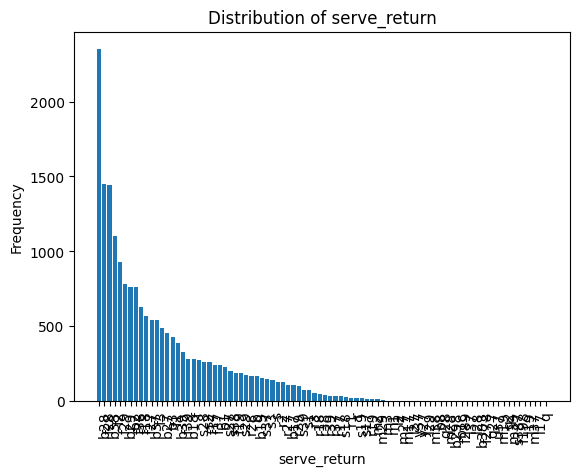

In [15]:
serve_return_column = df["serve_return"]
value_counts = serve_return_column.value_counts()

plt.bar(value_counts.index, value_counts.values )
plt.xlabel("serve_return")
plt.ylabel("Frequency")
plt.title("Distribution of serve_return")
plt.xticks(rotation=90)
plt.show()

In [16]:
serve_return_counts = df["serve_return"].value_counts().reset_index()
serve_return_counts.columns = ["serve_return", "frequency"]
serve_return_counts = serve_return_counts.sort_values("frequency", ascending=False )

serve_return_counts.head(10)


,serve_return,frequency
0,,2348
1,b28,1453
2,f28,1443
3,b38,1105
4,f2,927
5,f29,782
6,b29,766
7,b2,761
8,f38,627
9,f18,567


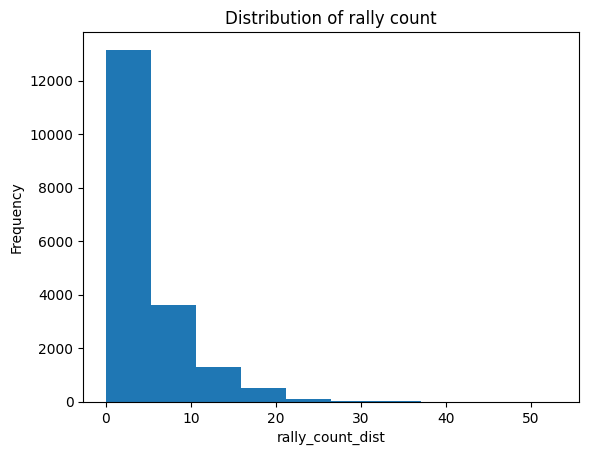

In [17]:
rally_count_dist = df["rallyCount"]
rally_count_dist = rally_count_dist.dropna()

plt.hist(rally_count_dist)
plt.xlabel("rally_count_dist")
plt.ylabel("Frequency")
plt.title("Distribution of rally count")
plt.show()

In [18]:
rally_counts = df["rallyCount"].value_counts().reset_index()
rally_counts.columns = ["rally_counts", "frequency"]
rally_counts = rally_counts.sort_values("frequency", ascending=False )

print(rally_counts)

    rally_counts  frequency
0              1       5127
1              3       2735
2              2       1753
3              5       1559
4              4       1377
5              6       1013
6              7        948
7              8        656
8              0        607
9              9        561
10            10        430
11            11        350
12            12        314
13            13        265
14            14        207
15            15        172
16            16        151
17            17        104
18            18         89
19            19         64
20            20         57
21            21         49
22            22         33
23            23         30
24            24         24
25            25         20
26            26          8
27            28          8
28            27          6
31            30          5
30            35          5
29            29          5
32            33          4
33            31          4
34            34    

## Geração das features

In [19]:
features = ['Surface',
            'Round',
            'Grand Slam',
            'i_serve',
            'is_second_service',
            'dir_srv',
            #'rallyCount',
            'rally_tratada',
            'isUnforced',
            'isForced',
            "serve_return",
            "how_ended"
            ]
X = df[features]
y = df['i_win']

In [20]:
feat_categorical = ['Surface','Round','dir_srv','serve_return','how_ended']

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18751 entries, 0 to 19323
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Surface            18751 non-null  object 
 1   Round              18751 non-null  object 
 2   Grand Slam         18751 non-null  int64  
 3   i_serve            18751 non-null  int64  
 4   is_second_service  18751 non-null  int64  
 5   dir_srv            18751 non-null  int64  
 6   rally_tratada      18751 non-null  float64
 7   isUnforced         18751 non-null  int64  
 8   isForced           18751 non-null  int64  
 9   serve_return       18751 non-null  object 
 10  how_ended          18751 non-null  object 
dtypes: float64(1), int64(6), object(4)
memory usage: 1.7+ MB


## separação - treino, teste e validação

In [22]:
from sklearn.model_selection import train_test_split

# Train-Test Split - ## parametro stratify ###
train, test = train_test_split(df, test_size=0.4)

# Train-Val Split
train, val = train_test_split(train, test_size=0.4)


In [23]:
## Separating features and target in the Train, Val and Test Set

X_train = train[features]
y_train = train['i_win']

X_val = val[features]
y_val = val['i_win']

X_test = test[features]
y_test = test['i_win']

In [24]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

6750 train examples
4500 validation examples
7501 test examples


In [25]:
X_train['serve_return'].nunique()

65

## Inicio do modelo - pre processamento e encoder

In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display="diagram")

In [27]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=["object"]))
)

preproc

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13f839e70>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13f83b790>)])

In [28]:
preproc.fit_transform(X_train).shape

(6750, 94)

In [29]:
X_train_preproc = preproc.fit_transform(X_train)
X_val_preproc = preproc.transform(X_val)
X_test_preproc = preproc.transform(X_test)

## Definição do modelo

In [30]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
model = Sequential()

# 1. Architecture
model.add(layers.Dense(32, activation='relu', input_shape=(X_train_preproc.shape[-1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# 2. Compiling
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [32]:
# 3. Training
es = EarlyStopping(monitor = 'val_accuracy',
                   patience = 10,
                   verbose = 0,
                   restore_best_weights = True)

history = model.fit(X_train_preproc,
                   y_train,
                   validation_data = (X_val_preproc, y_val),
                   batch_size = 64,
                   epochs = 500,
                   callbacks = [es], 
                   verbose = 1)

Epoch 1/500
106/106 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5539 - val_loss: 0.6530 - val_accuracy: 0.6758
Epoch 2/500
106/106 [==============================] - 0s 847us/step - loss: 0.6402 - accuracy: 0.6418 - val_loss: 0.5987 - val_accuracy: 0.6789
Epoch 3/500
106/106 [==============================] - 0s 879us/step - loss: 0.5952 - accuracy: 0.6627 - val_loss: 0.5602 - val_accuracy: 0.6818
Epoch 4/500
106/106 [==============================] - 0s 888us/step - loss: 0.5642 - accuracy: 0.6757 - val_loss: 0.5305 - val_accuracy: 0.6973
Epoch 5/500
106/106 [==============================] - 0s 860us/step - loss: 0.5355 - accuracy: 0.6941 - val_loss: 0.5117 - val_accuracy: 0.7033
Epoch 6/500
106/106 [==============================] - 0s 778us/step - loss: 0.5226 - accuracy: 0.6966 - val_loss: 0.4970 - val_accuracy: 0.7142
Epoch 7/500
106/106 [==============================] - 0s 929us/step - loss: 0.4994 - accuracy: 0.7138 - val_loss: 0.4869 - val_accu

## Resultado final / evaluate

In [33]:
res = model.evaluate(X_test_preproc, y_test)
print(f"accuracy = {res[1]:.3f}")

235/235 [==============================] - 0s 390us/step - loss: 0.4573 - accuracy: 0.7324
accuracy = 0.732


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3040      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                495       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 3551 (13.87 KB)
Trainable params: 3551 (13.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Verificação loss/accuracy - overfit / underfit

In [35]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

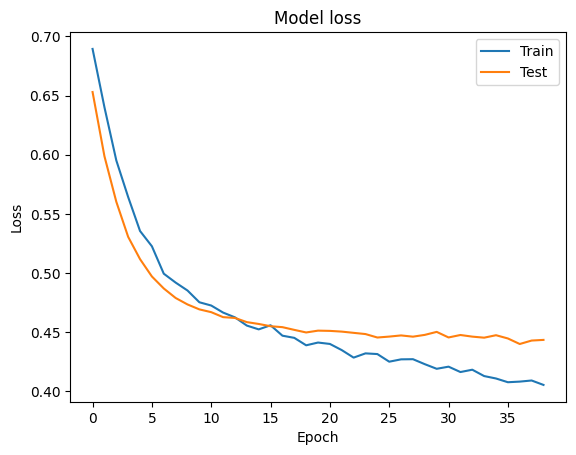

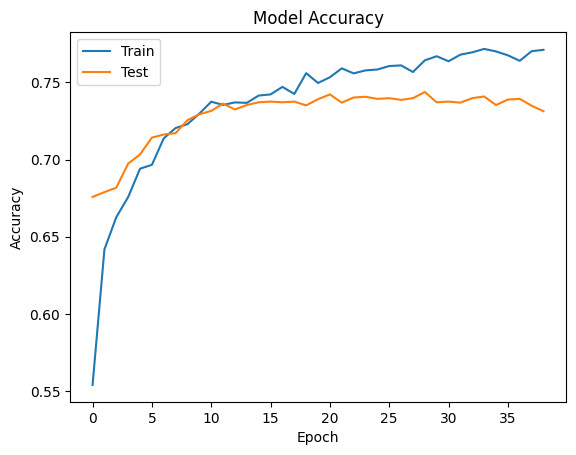

In [36]:
plot_loss_accuracy(history)